## PLAsTiCC v2.0 alert simulation 

This is a demo of how we can add catalog simulations to LSST alerts in avro forma, which the Rubin project is using. 
This workbook includes the contributions of Rahul Biswas, Cameron Stockton, Martine Lokken, Alex Gagliano, Gautham Narayan, Renée Hlozek and the rest of the PLAsTiCC v2.0 team, and the DESC Alerts Topical Team.

Follow the README of this repository and then the README of `alert_packet` for setup. This involves installing `alert_packet` in some way.

This notebook is based on the examples and codes in `alert_packet` :https://github.com/lsst/alert_packet

In [1]:
from IPython.display import Image
#Image(filename='alert.jpg', width = 800) 

In [2]:
import lsst.alert.packet

In [3]:
from pathlib import Path
import matplotlib.pyplot as plt
import os
from copy import copy
import json
from collections import OrderedDict as odict

import numpy as np
from astropy.io import fits
from astropy.table import Table, vstack

In [4]:
import json
import pandas as pd
from astropy.io import fits
import numpy as np
from astropy.time import Time
import glob
from fastavro import writer, reader
HOSTLIB_host=True

In [5]:
# taken from sncosmo
def read_snana_fits(head_file, phot_file, snids=None, n=None):
    """Read the SNANA FITS format: two FITS files jointly representing
    metadata and photometry for a set of SNe.

    Parameters
    ----------
    head_file : str
        Filename of "HEAD" ("header") FITS file.
    phot_file : str
        Filename of "PHOT" ("photometry") FITS file.
    snids : list of str, optional
        If given, only return the single entry with the matching SNIDs.
    n : int
        If given, only return the first `n` entries.

    Returns
    -------
    sne : list of `~astropy.table.Table`
        Each item in the list is an astropy Table instance.

    Notes
    -----
    If `head_file` contains a column 'SNID' containing strings, leading and
    trailing whitespace is stripped from all the values in that column.

    If `phot_file` contains a column 'FLT', leading and trailing whitespace
    is stripped from all the values in that column.

    Examples
    --------
    >>> sne = read_snana_fits('HEAD.fits', 'PHOT.fits')
    >>> for sn in sne:
    ...     sn.meta  # Metadata in an OrderedDict.
    ...     sn['MJD']  # MJD column

    """

    # Should we memmap? Only if we're going to read only a part of the file
    memmap = (snids is not None or n is not None)

    # Get metadata for all the SNe
    head_data = fits.getdata(head_file, 1, view=np.ndarray)
    phot_data = fits.getdata(phot_file, 1, view=np.ndarray, memmap=memmap)

    # Strip trailing whitespace characters from SNID.
    if 'SNID' in head_data.dtype.names:
        try:
            head_data['SNID'][:] = np.char.strip(head_data['SNID'])
        except TypeError:
            pass

    # Check which indicies to return.
    if snids is None and n is None:
        idx = range(len(head_data))
    elif n is None:
        if 'SNID' not in head_data.dtype.names:
            raise RuntimeError('Specific snids requested, but head file does'
                               ' not contain SNID column')
        idx = []
        for snid in snids:
            i = np.flatnonzero(head_data['SNID'] == snid)
            if len(i) != 1:
                raise RuntimeError('Unique snid requested, but there are '
                                   '{0:d} matching entries'.format(len(i)))
            idx.append(i[0])
    elif snids is None:
        idx = range(n)
    else:
        raise ValueError("cannot specify both 'snids' and 'n' arguments")

    # Loop over SNe in HEAD file
    sne = []
    for i in idx:
        meta = odict(zip(head_data.dtype.names, head_data[i]))

        j0 = head_data['PTROBS_MIN'][i] - 1
        j1 = head_data['PTROBS_MAX'][i]
        data = phot_data[j0:j1]
        if 'BAND' in data.dtype.names:
            data['BAND'][:] = np.char.strip(data['BAND'])
        sne.append(Table(data, meta=meta, copy=False))

    return sne

### These functions will enable us to plot the output from our avro object
Example functions taken from https://github.com/ZwickyTransientFacility/ztf-avro-alert/blob/master/notebooks/Working_with_avro_files.ipynb

In [6]:
def make_dataframe(packet):
    df = pd.DataFrame(packet['diaSource'], index=[0])
    df_prv = pd.DataFrame(packet['prvDiaSources'])
    return pd.concat([df,df_prv], ignore_index=True)

def plot_lightcurve(dflc, days_ago=True):
    
    filter_color = {'g':'green', 'r':'red', 'u':'pink'}
    if days_ago:
        now = Time.now().jd
        t = dflc.midPointTai - now
        xlabel = 'Days Ago'
    else:
        t = dflc.midPointTai
        xlabel = 'Time (JD)'
    
    plt.figure()
    
    for fid, color in filter_color.items():
        # plot detections in this filter:
        w = (dflc.filterName == fid) & ~dflc.psFlux.isnull()
        if np.sum(w):
            plt.errorbar(t[w],dflc.loc[w,'apFlux'], dflc.loc[w,'apFluxErr'],fmt='.',color=color)
            
        else:
            plt.errorbar(t[w],dflc.loc[w,'apFlux'], dflc.loc[w,'apFluxErr'],fmt='.',color=color)
                
        #wnodet = (dflc.fid == fid) & dflc.magpsf.isnull()
        #if np.sum(wnodet):
         #   plt.scatter(t[wnodet],dflc.loc[wnodet,'diffmaglim'], marker='v',color=color,alpha=0.25)
    
    plt.gca().invert_yaxis()
    plt.xlabel(xlabel)
    plt.ylabel('Magnitude')

### Let's read in the schema from the Rubin alert.packet 
In this case we are modifying the usual alert schema to have (lots of) additional information in it. The expected list of host information will be more like host magnitudes and host errors, the light profile moments and PSF information. 

In [7]:
import os
os.chdir("../Examples")

In [8]:
# For those interested in modified alert schemas, this is included in the repo as an example, modified from the `alert_packet' repo
#schema = lsst.alert.packet.Schema.from_file('./plasticc_schema/lsst.v4_1.alert.avsc','lsst.v4_1.alert')
schema = lsst.alert.packet.Schema.from_file(filename='./plasticc_schema/lsst.v4_1.alert.avsc')

We now read in an example json file that matches our schema.

In [9]:
path = Path('./plasticc_schema/sample_data/')
with open(path/'plasticc.json') as f:
    alert_data = json.load(f)


### What does the alert data schema look like?
It has one diaSource object for the current epoch

In [10]:
alert_data['diaSource']

{'diaSourceId': 281323062375219200,
 'ccdVisitId': 111111,
 'midPointTai': 1480360995,
 'filterName': 'r',
 'programId': 1,
 'ra': 351.570546978,
 'decl': 0.126243049656,
 'raSigma': 0.00028,
 'declSigma': 0.00028,
 'ra_decl_Cov': 0.00029,
 'x': 112.1,
 'y': 121.1,
 'xSigma': 1.2,
 'ySigma': 1.1,
 'x_y_Cov': 1.2,
 'apFlux': 1241.0,
 'apFluxErr': 12.0,
 'snr': 41.1,
 'psFlux': 1241.0,
 'psFluxErr': 12.0,
 'flags': 0,
 'nobs': 0,
 'mwebv': 0,
 'mwebv_err': 0,
 'z_final': 0,
 'z_final_err': 0,
 'ellipticity': 0,
 'size': 0,
 'hostgal_z': 0,
 'hostgal_mag_u': 0,
 'hostgal_mag_g': 0,
 'hostgal_mag_r': 0,
 'hostgal_mag_i': 0,
 'hostgal_mag_z': 0,
 'hostgal_mag_Y': 0,
 'hostgal_ra': 0,
 'hostgal_dec': 0,
 'hostgal_snsep': 0,
 'hostgal_magerr_u': 0,
 'hostgal_magerr_g': 0,
 'hostgal_magerr_r': 0,
 'hostgal_magerr_i': 0,
 'hostgal_magerr_z': 0,
 'hostgal_magerr_Y': 0,
 'ellipticity2': 0,
 'size2': 0,
 'hostgal2_z': 0,
 'hostgal2_mag_u': 0,
 'hostgal2_mag_g': 0,
 'hostgal2_mag_r': 0,
 'hostgal2_

### What about previous diaSources?
The previous diaSources for this diaObject are also nested in the schema

In [11]:
alert_data['prvDiaSources']

[{'diaSourceId': 281323062375219198,
  'ccdVisitId': 111111,
  'midPointTai': 1480360995,
  'filterName': 'r',
  'programId': 1,
  'ra': 351.570546978,
  'decl': 0.126243049656,
  'raSigma': 0.00028,
  'declSigma': 0.00028,
  'ra_decl_Cov': 0.00029,
  'x': 112.1,
  'y': 121.1,
  'xSigma': 1.2,
  'ySigma': 1.1,
  'x_y_Cov': 1.2,
  'apFlux': 1241.0,
  'apFluxErr': 12.0,
  'snr': 41.1,
  'psFlux': 1241.0,
  'psFluxErr': 12.0,
  'flags': 0,
  'nobs': 0,
  'mwebv': 0,
  'mwebv_err': 0,
  'z_final': 0,
  'z_final_err': 0,
  'ellipticity': 0,
  'size': 0,
  'hostgal_z': 0,
  'hostgal_mag_u': 0,
  'hostgal_mag_g': 0,
  'hostgal_mag_r': 0,
  'hostgal_mag_i': 0,
  'hostgal_mag_z': 0,
  'hostgal_mag_Y': 0,
  'hostgal_ra': 0,
  'hostgal_dec': 0,
  'hostgal_snsep': 0,
  'hostgal_magerr_u': 0,
  'hostgal_magerr_g': 0,
  'hostgal_magerr_r': 0,
  'hostgal_magerr_i': 0,
  'hostgal_magerr_z': 0,
  'hostgal_magerr_Y': 0,
  'ellipticity2': 0,
  'size2': 0,
  'hostgal2_z': 0,
  'hostgal2_mag_u': 0,
  'host

This alert schema is just a dictionary: next we will read data from SNANA and write it to the values of the correct keys. We start by pulling off the first record to overwrite with SNANA information

In [12]:
diasrc = alert_data['prvDiaSources'][0]

In [13]:
diasrc.keys()

dict_keys(['diaSourceId', 'ccdVisitId', 'midPointTai', 'filterName', 'programId', 'ra', 'decl', 'raSigma', 'declSigma', 'ra_decl_Cov', 'x', 'y', 'xSigma', 'ySigma', 'x_y_Cov', 'apFlux', 'apFluxErr', 'snr', 'psFlux', 'psFluxErr', 'flags', 'nobs', 'mwebv', 'mwebv_err', 'z_final', 'z_final_err', 'ellipticity', 'size', 'hostgal_z', 'hostgal_mag_u', 'hostgal_mag_g', 'hostgal_mag_r', 'hostgal_mag_i', 'hostgal_mag_z', 'hostgal_mag_Y', 'hostgal_ra', 'hostgal_dec', 'hostgal_snsep', 'hostgal_magerr_u', 'hostgal_magerr_g', 'hostgal_magerr_r', 'hostgal_magerr_i', 'hostgal_magerr_z', 'hostgal_magerr_Y', 'ellipticity2', 'size2', 'hostgal2_z', 'hostgal2_mag_u', 'hostgal2_mag_g', 'hostgal2_mag_r', 'hostgal2_mag_i', 'hostgal2_mag_z', 'hostgal2_mag_Y', 'hostgal2_ra', 'hostgal2_dec', 'hostgal2_snsep', 'hostgal2_magerr_u', 'hostgal2_magerr_g', 'hostgal2_magerr_r', 'hostgal2_magerr_i', 'hostgal2_magerr_z', 'hostgal2_magerr_Y'])

## Taking an SNANA file and porting information to alert
We will pull off models from the PLAsTiCC v2.0 DDF simulation, and assign the info to the alert packet. Note that we are adding information that isn't in the defined in the original LSST schema for this round. The following code takes the photometry and header files from SNANA and pushes them to a diaSource object for an index/epoch

In [14]:
def import_diasrc_from_fits(sn, my_diasrc,hostlib_flag=True,i=0):
    
        my_diasrc['filterName'] = sn['BAND'][i]     
        my_diasrc['apFlux'] = sn['FLUXCAL'][i]
        my_diasrc['apFluxErr'] = sn['FLUXCALERR'][i]
        my_diasrc['snr'] = sn['FLUXCAL'][i]/sn['FLUXCALERR'][i]
        my_diasrc['midPointTai'] = sn['MJD'][i]
    
        # General properties
        my_diasrc['ra'] = sn.meta['RA']
        my_diasrc['decl'] = sn.meta['DEC']
        my_diasrc['nobs'] = sn.meta['NOBS']
        my_diasrc['mwebv'] = sn.meta['MWEBV']
        my_diasrc['mwebv_err'] = sn.meta['MWEBV_ERR']
        my_diasrc['z_final'] = sn.meta['REDSHIFT_FINAL']
        my_diasrc['z_final_err'] = sn.meta['REDSHIFT_FINAL_ERR']
        my_diasrc['hostgal_ra'] = sn.meta['HOSTGAL_RA']
        my_diasrc['hostgal_dec'] = sn.meta['HOSTGAL_DEC']
        my_diasrc['hostgal_snsep']= sn.meta['HOSTGAL_SNSEP']
        my_diasrc['hostgal_z']=sn.meta['HOSTGAL_SPECZ']
        my_diasrc['hostgal_z_err']=sn.meta['HOSTGAL_SPECZ_ERR']   
        my_diasrc['hostgal_mag_u']= sn.meta['HOSTGAL_MAG_u']
        my_diasrc['hostgal_mag_g']= sn.meta['HOSTGAL_MAG_g']
        my_diasrc['hostgal_mag_r']= sn.meta['HOSTGAL_MAG_r']
        my_diasrc['hostgal_mag_i']= sn.meta['HOSTGAL_MAG_i']
        my_diasrc['hostgal_mag_z']= sn.meta['HOSTGAL_MAG_z']
        my_diasrc['hostgal_mag_Y']= sn.meta['HOSTGAL_MAG_Y']
        my_diasrc['hostgal_magerr_u']= sn.meta['HOSTGAL_MAGERR_u']
        my_diasrc['hostgal_magerr_g']= sn.meta['HOSTGAL_MAGERR_g']
        my_diasrc['hostgal_magerr_r']= sn.meta['HOSTGAL_MAGERR_r']
        my_diasrc['hostgal_magerr_i']= sn.meta['HOSTGAL_MAGERR_i']
        my_diasrc['hostgal_magerr_z']= sn.meta['HOSTGAL_MAGERR_z']
        
        my_diasrc['hostgal2_ra'] = sn.meta['HOSTGAL2_RA']
        my_diasrc['hostgal2_dec'] = sn.meta['HOSTGAL2_DEC']
        my_diasrc['hostgal2_snsep']= sn.meta['HOSTGAL2_SNSEP']
        my_diasrc['hostgal2_z']=sn.meta['HOSTGAL2_SPECZ']
        my_diasrc['hostgal2_z_err']=sn.meta['HOSTGAL2_SPECZ_ERR']   
        my_diasrc['hostgal2_mag_u']= sn.meta['HOSTGAL2_MAG_u']
        my_diasrc['hostgal2_mag_g']= sn.meta['HOSTGAL2_MAG_g']
        my_diasrc['hostgal2_mag_r']= sn.meta['HOSTGAL2_MAG_r']
        my_diasrc['hostgal2_mag_i']= sn.meta['HOSTGAL2_MAG_i']
        my_diasrc['hostgal2_mag_z']= sn.meta['HOSTGAL2_MAG_z']
        my_diasrc['hostgal2_mag_Y']= sn.meta['HOSTGAL2_MAG_Y']
        my_diasrc['hostgal2_magerr_u']= sn.meta['HOSTGAL2_MAGERR_u']
        my_diasrc['hostgal2_magerr_g']= sn.meta['HOSTGAL2_MAGERR_g']
        my_diasrc['hostgal2_magerr_r']= sn.meta['HOSTGAL2_MAGERR_r']
        my_diasrc['hostgal2_magerr_i']= sn.meta['HOSTGAL2_MAGERR_i']
        my_diasrc['hostgal2_magerr_z']= sn.meta['HOSTGAL2_MAGERR_z']
        
        if hostlib_flag:
            # properties of the host galaxy
           # print('using HOSTLIB values')
            my_diasrc['ellipticity'] = sn.meta['SIM_HOSTLIB(TOTAL_ELLIPTICITY)']
            my_diasrc['size'] = sn.meta['SIM_HOSTLIB(radius)']
            my_diasrc['hostgal_mag_u'] = sn.meta['SIM_HOSTLIB(mag_true_u_lsst)']
            my_diasrc['hostgal_mag_g'] = sn.meta['SIM_HOSTLIB(mag_true_g_lsst)']
            my_diasrc['hostgal_mag_r'] = sn.meta['SIM_HOSTLIB(mag_true_r_lsst)']
            my_diasrc['hostgal_mag_i'] = sn.meta['SIM_HOSTLIB(mag_true_i_lsst)']
            my_diasrc['hostgal_mag_z'] = sn.meta['SIM_HOSTLIB(mag_true_z_lsst)']
            my_diasrc['hostgal_mag_Y'] = sn.meta['SIM_HOSTLIB(mag_true_Y_lsst)']
            
            my_diasrc['ellipticity2'] = sn.meta['SIM_HOSTLIB(TOTAL_ELLIPTICITY)']
            my_diasrc['size2'] = sn.meta['SIM_HOSTLIB(radius)']
            my_diasrc['hostgal2_mag_u'] = sn.meta['HOSTGAL2_MAG_u']
            my_diasrc['hostgal2_mag_g'] = sn.meta['HOSTGAL2_MAG_g']
            my_diasrc['hostgal2_mag_r'] = sn.meta['HOSTGAL2_MAG_r']
            my_diasrc['hostgal2_mag_i'] = sn.meta['HOSTGAL2_MAG_i']
            my_diasrc['hostgal2_mag_z'] = sn.meta['HOSTGAL2_MAG_z']
            my_diasrc['hostgal2_mag_Y'] = sn.meta['HOSTGAL2_MAG_Y']
            
            my_diasrc['hostgal_magerr_u']= sn.meta['SIM_HOSTLIB(u_obs_err)']
            my_diasrc['hostgal_magerr_g']= sn.meta['SIM_HOSTLIB(g_obs_err)']
            my_diasrc['hostgal_magerr_r']= sn.meta['SIM_HOSTLIB(r_obs_err)']
            my_diasrc['hostgal_magerr_i']= sn.meta['SIM_HOSTLIB(i_obs_err)']
            my_diasrc['hostgal_magerr_z']= sn.meta['SIM_HOSTLIB(z_obs_err)']
            my_diasrc['hostgal_magerr_Y']= sn.meta['SIM_HOSTLIB(Y_obs_err)']
            
            my_diasrc['hostgal2_magerr_u']= sn.meta['SIM_HOSTLIB(u_obs_err)']
            my_diasrc['hostgal2_magerr_g']= sn.meta['SIM_HOSTLIB(g_obs_err)']
            my_diasrc['hostgal2_magerr_r']= sn.meta['SIM_HOSTLIB(r_obs_err)']
            my_diasrc['hostgal2_magerr_i']= sn.meta['SIM_HOSTLIB(i_obs_err)']
            my_diasrc['hostgal2_magerr_z']= sn.meta['SIM_HOSTLIB(z_obs_err)']
            my_diasrc['hostgal2_magerr_Y']= sn.meta['SIM_HOSTLIB(Y_obs_err)']
   
        return my_diasrc

Now we read in the data from a particular SNANA model. In this case we are using a small SNANA simulation that includes the host properties (from work by Martine Lokken and Alex Gagliano). The full PLAsTiCC suite will contain alerts for a range of different objects from a variety of models.

In [15]:
savedir='/global/homes/a/agaglian/new_plasticc_alerts/plasticc_alerts/hostSims'
os.chdir(savedir)
retval = "../Examples"
simdir='../hostSims/'
os.chdir(simdir)
modelname = glob.glob('*MODEL*')
num_sne =3 #how many supernova alerts you want to make

Running alerts for the model list: ['MLAG_HOSTLIB_Ia_NONIaMODEL0']
Saving model MLAG_HOSTLIB_Ia_NONIaMODEL0 as plasticcAlert_MLAG_HOSTLIB_Ia_NONIaMODEL0_0.avro
Saving model MLAG_HOSTLIB_Ia_NONIaMODEL0 as plasticcAlert_MLAG_HOSTLIB_Ia_NONIaMODEL0_1.avro
Saving model MLAG_HOSTLIB_Ia_NONIaMODEL0 as plasticcAlert_MLAG_HOSTLIB_Ia_NONIaMODEL0_2.avro
Done saving models for ['MLAG_HOSTLIB_Ia_NONIaMODEL0']
Done saving all models


<Figure size 864x4320 with 0 Axes>

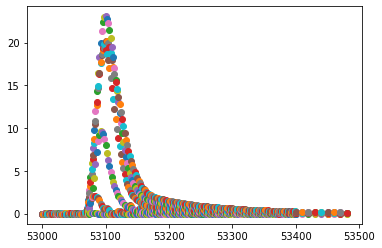

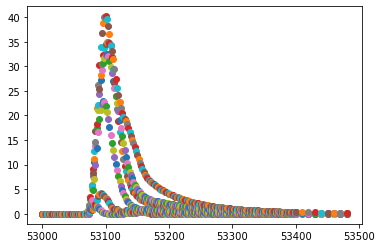

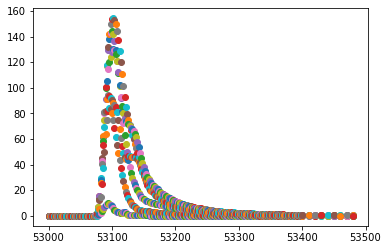

In [16]:
os.chdir(retval)
print(f"Running alerts for the model list: {modelname}")

path = Path('plasticc_schema/sample_data')
with open(path/'plasticc.json') as f:
    alert_data_orig = json.load(f)
    
#print(alert_data_orig)
    
fig = plt.figure(figsize=(12,60))
number_of_subplots=len(modelname)
#print(number_of_subplots)

for countm,name in enumerate(modelname):
    #print(name)
    # Open the photometry file and the header files
    name_head=simdir+'/'+name+'/'+'%s-0001_HEAD.FITS.gz'%name
    name_phot=simdir+'/'+name+'/'+'%s-0001_PHOT.FITS.gz'%name
    
    sne = read_snana_fits(name_head, name_phot)
    
    
    #print(sne[0].meta)
    #print('-----')
    for iterNum,sn in enumerate(sne[0:num_sne]):
        #print(sn.colnames)
        ra = sn.meta['RA']
        mjd = sn['MJD']
        #print(sn['FLUXCALERR'])
        alert = copy(alert_data_orig)
    
        diasrc = alert_data_orig['prvDiaSources'][0]
        my_diasrc = copy(diasrc)
        alert = copy(alert_data_orig)
        alert['prvDiaSources'].clear()


        # Make a dummy source ID and import additional information to the diaSource
        my_diasrc['diaSourceId'] = np.int64(28132306237521+1000*np.random.uniform())
        my_diasrc = import_diasrc_from_fits(sn,my_diasrc,HOSTLIB_host,i=0)
        alert['diaSource'] = my_diasrc
        
        for j, day in enumerate(mjd):
            my_diasrc = copy(diasrc)
            my_diasrc['diaSourceId'] = my_diasrc['diaSourceId']+j+1
            plt.figure(iterNum*100)
            #print(mjd[j],sn['FLUXCAL'][j])
            #print(sn['FLUXCALERR'][j])
            plt.scatter(day,sn['FLUXCAL'][j], marker='o' )
            my_diasrc = import_diasrc_from_fits(sn,my_diasrc,HOSTLIB_host,i=j)
            alert['prvDiaSources'].append(alert['diaSource'])

        # serialize the alert    
        avro_bytes = schema.serialize(alert)
        messg = schema.deserialize(avro_bytes)
        

        with open("plasticcAlert_%s_%i.avro"%(name,iterNum), "wb") as f:
            schema.store_alerts(f, [alert])
        print(f"Saving model {name} as plasticcAlert_{name}_{iterNum}.avro")

    print(f"Done saving models for {modelname}")
print(f"Done saving all models")


['plasticcAlert_MLAG_HOSTLIB_Ia_NONIaMODEL0_0.avro', 'plasticcAlert_MLAG_HOSTLIB_Ia_NONIaMODEL0_1.avro', 'plasticcAlert_MLAG_HOSTLIB_Ia_NONIaMODEL0_2.avro']
Reading /global/homes/a/agaglian/new_plasticc_alerts/plasticc_alerts/Examples/plasticcAlert_MLAG_HOSTLIB_Ia_NONIaMODEL0_0.avro


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.6.0/lib/python3.8/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


Reading /global/homes/a/agaglian/new_plasticc_alerts/plasticc_alerts/Examples/plasticcAlert_MLAG_HOSTLIB_Ia_NONIaMODEL0_1.avro


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.6.0/lib/python3.8/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


Reading /global/homes/a/agaglian/new_plasticc_alerts/plasticc_alerts/Examples/plasticcAlert_MLAG_HOSTLIB_Ia_NONIaMODEL0_2.avro


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.6.0/lib/python3.8/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


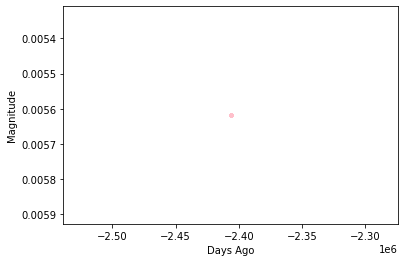

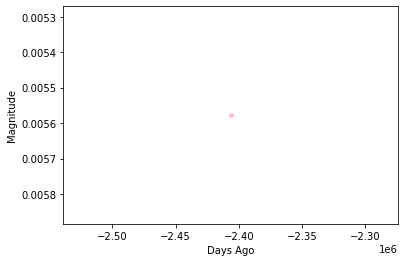

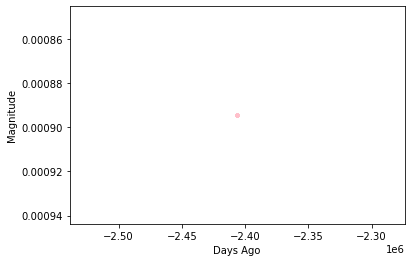

In [17]:
savedir='/global/homes/a/agaglian/new_plasticc_alerts/plasticc_alerts/Examples'
for countm,name in enumerate(modelname):
    sne=glob.glob("*{}*.avro".format(name))
    print(sne)
    for cn, sn in enumerate(sne):
        fname= savedir+'/'+"plasticcAlert_%s_%i.avro"%(name,cn)
        print(f"Reading {fname}")
        with open(fname,'rb') as f:
            freader = reader(f)
            for alert in freader:
                dflc = make_dataframe(alert)
                plot_lightcurve(dflc)

In [18]:
alert

{'alertId': 1231321321,
 'diaSource': {'diaSourceId': 28132306237593,
  'ccdVisitId': 111111,
  'diaObjectId': None,
  'ssObjectId': None,
  'parentDiaSourceId': None,
  'midPointTai': 53000.0,
  'filterName': 'u',
  'programId': 1,
  'ra': 67.29573746133228,
  'decl': -43.36066438573713,
  'raErr': None,
  'declErr': None,
  'ra_decl_Cov': 0.0002899999963119626,
  'x': 112.0999984741211,
  'y': 121.0999984741211,
  'xErr': None,
  'yErr': None,
  'x_y_Cov': 1.2000000476837158,
  'apFlux': 0.0008944925502873957,
  'apFluxErr': nan,
  'snr': nan,
  'psFlux': 1241.0,
  'psFluxErr': 12.0,
  'psRa': None,
  'psDecl': None,
  'psRaErr': None,
  'psDeclErr': None,
  'psFlux_psRa_Cov': None,
  'psFlux_psDecl_Cov': None,
  'psRa_psDecl_Cov': None,
  'psLnL': None,
  'psChi2': None,
  'psNdata': None,
  'trailFlux': None,
  'trailRa': None,
  'trailDecl': None,
  'trailLength': None,
  'trailAngle': None,
  'trailFluxErr': None,
  'trailRaErr': None,
  'trailDeclErr': None,
  'trailLengthErr': 